In [1]:
import cv2
import glob
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown

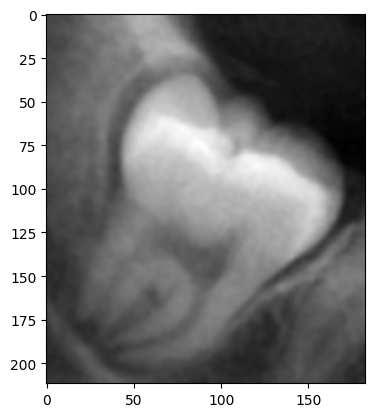

In [19]:
def open_img(image_path):
    """
            Funcao responsavel por carregar imagens de um diretorio
            Arguments:
              image_path: Caminho do diretorio das imagens
            Return:
              dataset: Vetor, onde cada posição possui uma imagem carregada do diretório
        """
    dataset = []
    #carrega as imagens do diretorio
    for i in glob.glob(image_path + '/*.png', recursive=True):
        dataset.append(cv2.imread(i))
    for j in glob.glob(image_path + '/*.jpg', recursive=True):
        dataset.append(cv2.imread(j))
    # for k in glob.glob(image_path + '/*.gif', recursive=True):
    #     dataset.append(cv2.imread(k))

    return dataset

dataset = open_img('dataset/')
dataset_gray = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in dataset]
dataset_gray = [cv2.GaussianBlur(image,(5,5),0) for image in dataset_gray]
plt.imshow(dataset_gray[5],cmap='gray')

## Limiar adaptativo

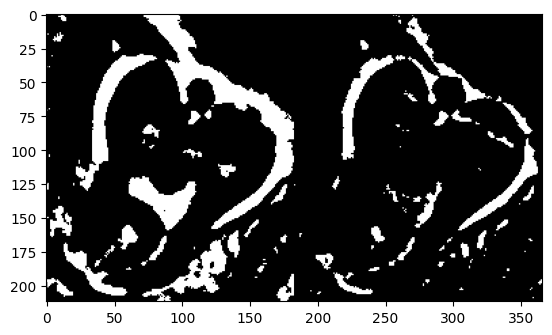

In [20]:
image = dataset_gray[5].copy()
thresh_mean = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                          cv2.THRESH_BINARY_INV, 35, 5) 
  
thresh_gaussian = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY_INV, 35, 5) 
thresh_adaptative = np.hstack((thresh_mean,thresh_gaussian))
#cv2.imwrite("thresh_adaptative_comp",thresh_adaptative)
plt.imshow(thresh_adaptative,cmap='gray')
  

## Limiar de OTSU

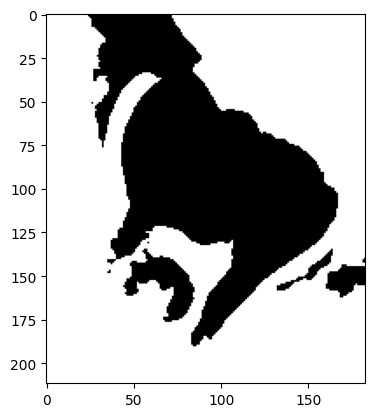

In [22]:
image = dataset_gray[5].copy()

thresh_otsu = cv2.threshold(image, 0, 255,
                           cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(thresh_otsu,cmap='gray')                  

## Gaussian Filter


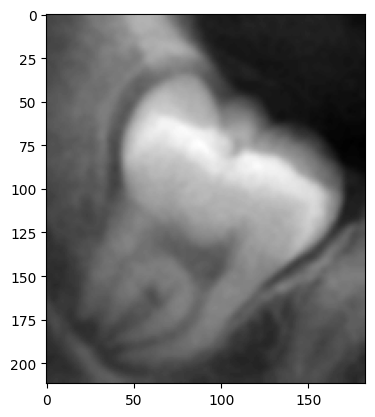

In [23]:
image = dataset_gray[5].copy()
filter_gaussian = cv2.GaussianBlur(image,(5,5),0)
plt.imshow(filter_gaussian,cmap='gray') 

## Correção Gamma

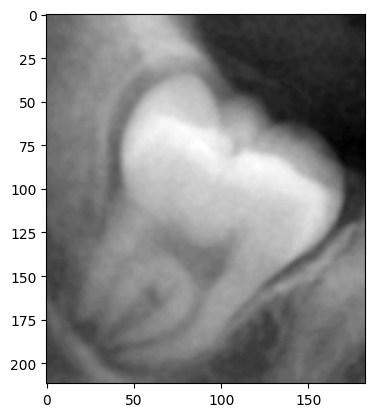

In [26]:
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(src, table)

image = dataset_gray[5].copy()
gamma = gammaCorrection(image, 3)
plt.imshow(gamma,cmap='gray') 

## Watershed

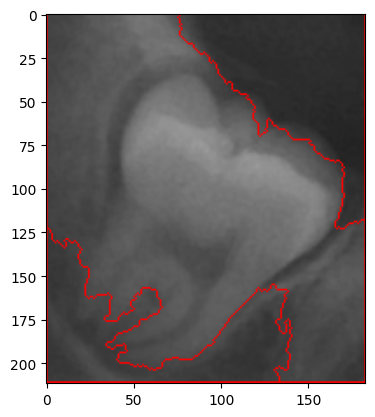

In [27]:
def watershed(image): 
    image_gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(image_gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

    # aplica abertura 
    kernel = np.ones((3,3),np.uint8)
    image_open = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 5)

    # dilata a imagem
    image_dilate = cv2.dilate(image_open,kernel,iterations=3)

    # encontra a area
    dist_transform = cv2.distanceTransform(image_open,cv2.DIST_L2,5)
    imagebinary = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)[1]

    # encontra a região
    imagebinary = np.uint8(imagebinary)
    unknown = cv2.subtract(image_dilate,imagebinary)
    markers = cv2.connectedComponents(imagebinary)[1]

    markers = markers+1
    markers[unknown==255] = 0

    markers = cv2.watershed(image,markers)
    image[markers == -1] = [255,0,0]
    return image, markers

image = dataset[5].copy()
image_watershed = watershed(image)
plt.imshow(image_watershed[0],cmap='gray') 

## Kmeans

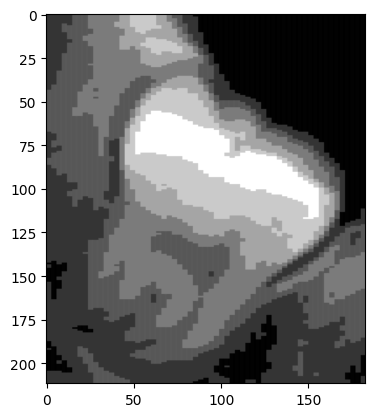

In [28]:
def kmeans(image,K):
    Z = image.reshape((-1,3))
    shape = image.shape
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    image = center[label.flatten()]
    image = image.reshape((shape))
    
    return image

image = dataset_gray[5].copy()
kmeans = kmeans(image,7)
plt.imshow(kmeans,cmap='gray') 

## Operação morfológica

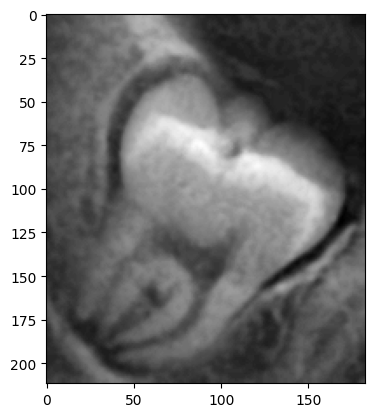

In [29]:
image = dataset_gray[5].copy()
structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25,25))
image_tophat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, structuring_element)
transf = cv2.add(image, image_tophat)

image_blackhat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, structuring_element)
transf = cv2.subtract(transf, image_blackhat)
plt.imshow(transf,cmap='gray') 